In [1]:
import os
import json
import numpy as np
import torch
from torch import nn
import torchvision
import random
from tqdm import *
from PIL import Image
from io import StringIO, BytesIO
import lpips

import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader


from pro_gan_pytorch.networks import create_generator_from_saved_model, create_generator_from_saved_model_opt
from pro_gan_pytorch.utils import adjust_dynamic_range
from torch.nn.functional import interpolate
import torchvision.transforms.functional as fn
from train_log import MeanTracker

from torch.utils.tensorboard import SummaryWriter

import model_rs as recsys_models


In [8]:
device = 1
seed = 0

data_train = 'amazon'
out_dir = 'dummy_rec/'
latent_dim = 512
learning_rate = 0.00002
training_epoch = 1000
batch_size = 1
numofworkers= 4
gan_weights= '../PROGAN_AM_Fashion/Model_log_base/models/depth_7_epoch_50.bin' 

torch.cuda.set_device(device)
print('Cuda is Available: ', torch.cuda.is_available())
random.seed(seed)
torch.random.manual_seed(seed)

# print('Seed val fixed to: ', seed)


if data_train == 'amazon':

    dataset_name = 'AmazonFashion6ImgPartitioned.npy'
    dataset = np.load('../DVBPR/dataset/'+ dataset_name, encoding='bytes', allow_pickle=True)
    [user_train, _, _, Item, usernum, itemnum] = dataset

elif data_train == 'tradesy':

    dataset_name = 'TradesyImgPartitioned.npy'
    dataset = np.load('../DVBPR/data/' + dataset_name, encoding='bytes')
    [user_train, user_validation, user_test, Item, usernum, itemnum] = dataset
    cold_list = np.load('../data/tradesy_one_k_cold.npy')


def default_loader(path):
    img_pil =  Image.open(BytesIO(path)).convert('RGB')
    img_tensor = input_transform(img_pil)
    return img_tensor

# input_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406],
#     #                     std=[0.229, 0.224, 0.225])
#     # transforms.Normalize((0.6949, 0.6748, 0.6676), (0.3102, 0.3220, 0.3252))])
#     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
#     ])


input_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

class trainset(Dataset):
    def __init__(self, loader=default_loader):
        self.images_i = file_train_i
        self.images_j = file_train_j
        self.target = train_ls
        self.loader = loader

    def __getitem__(self, index):
        fn_i = self.images_i[index]
        img_i = self.loader(fn_i)
        fn_j = self.images_j[index]
        img_j = self.loader(fn_j)
        target = self.target[index]
        return img_i, img_j, target[0], target[1], target[2]

    def __len__(self):
        return len(self.images_i)



# helper scale function
def scale(x):
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = (x - x.min()) / (x.max() - x.min())
    return x

def scale_synth(x):
    # scale to feature_range and return scaled x
    x = adjust_dynamic_range(x,drange_in=(-1.0, 1.0), drange_out=(0.0, 1.0))
    return x

def scale_percept(x):
    # scale to feature_range and return scaled x
    x = adjust_dynamic_range(x,drange_in=(-1.0, 1.0), drange_out=(-1.0, 1.0))

    return x

def manual_normalize(x, mean, std):
    mean_ten = torch.Tensor(mean).unsqueeze(dim=0).unsqueeze(dim=2).unsqueeze(dim=3).cuda()
    std_ten = torch.Tensor(std).unsqueeze(dim=0).unsqueeze(dim=2).unsqueeze(dim=3).cuda()
    x = (x-mean_ten)/std_ten
    return x

def scale_rs(x):
    x = adjust_dynamic_range(x,drange_in=(-1.0, 1.0), drange_out=(0.0, 1.0))
    x = interpolate(x, size=(224, 224), mode='bilinear')
    x = manual_normalize(x, mean=[0.6949, 0.6748, 0.6676], std=[0.3102, 0.3220, 0.3252])
    return x


##### Initialize Dataset Object ######
def sample(user):
    u = random.randrange(usernum)
    numu = len(user[u])
    i = user[u][random.randrange(numu)][b'productid']
    M=set()
    for item in user[u]:
        M.add(item[b'productid'])
    while True:
        j=random.randrange(itemnum)
        if (not j in M): break
    return (u,i,j)

oneiteration = 0
for item in user_train: oneiteration+=len(user_train[item])

train_ls = [list(sample(user_train)) for _ in range(oneiteration)]

class_val = 2
file_train_i = [Item[i][b'imgs'] for i in range(itemnum) if class_val in np.argwhere(Item[i][b'c']==True)]
file_train_j = [Item[i][b'imgs'] for i in range(itemnum) if class_val not in np.argwhere(Item[i][b'c']==True)]


train_dataset  = trainset()


data_loader_train = DataLoader(train_dataset, batch_size = 25, shuffle=True, num_workers = numofworkers, drop_last=True)
print("Total number of Train Samples: ",len(train_dataset))


Cuda is Available:  True


Total number of Train Samples:  4005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


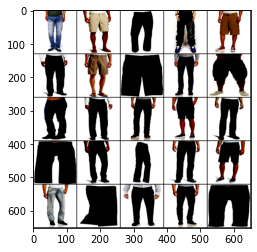

In [9]:
x, _, u, _, _ = next(iter(data_loader_train))
import matplotlib.pyplot as plt
k = torchvision.utils.make_grid(x, nrow=5)
k.shape
plt.imshow(k.permute(1,2,0))